<a href="https://colab.research.google.com/github/GuojunWu/Spacecraft_VAE/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

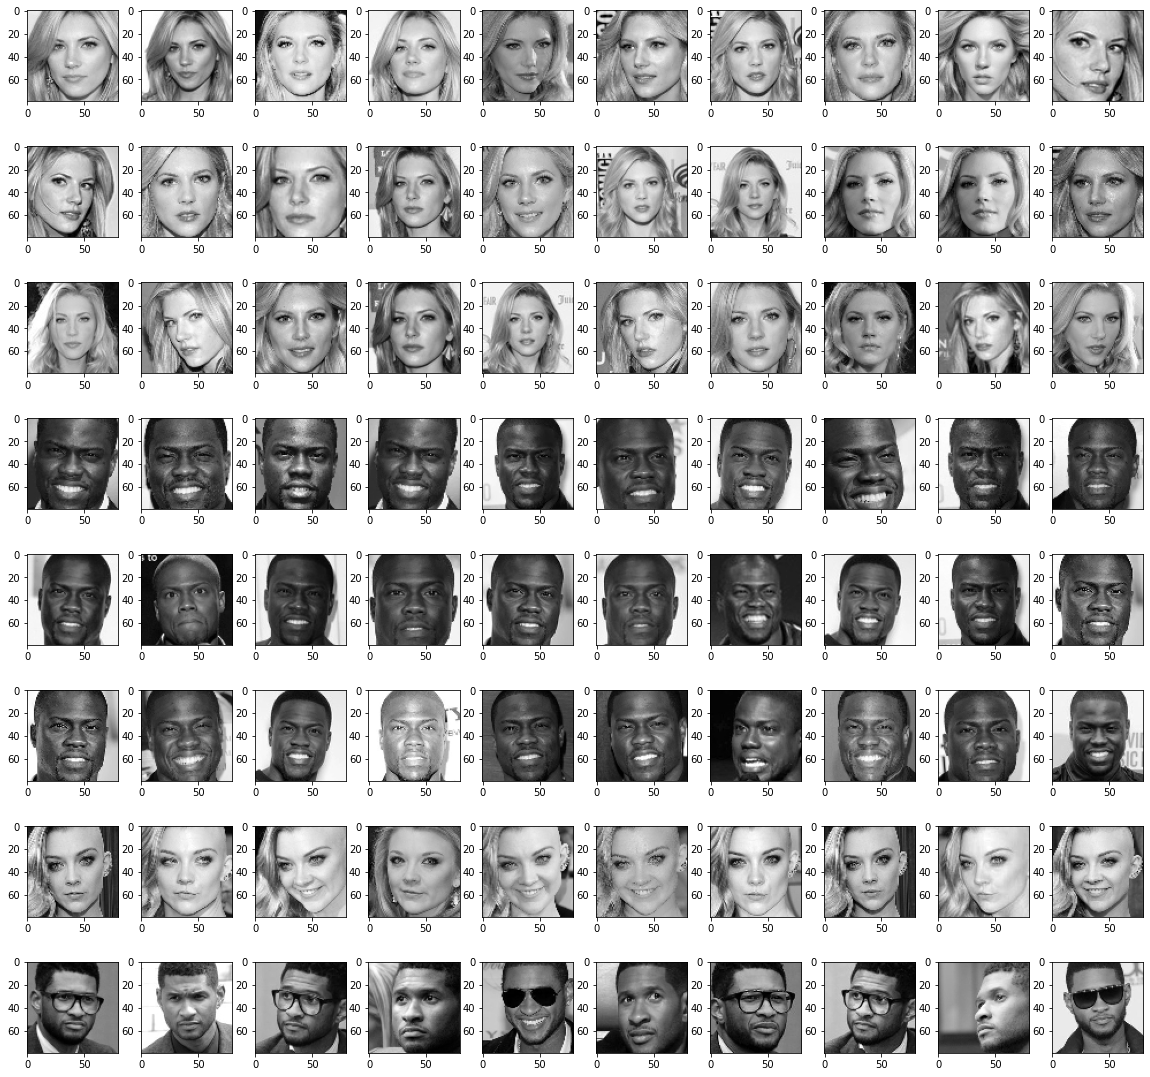

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

base_path = "/content/sample_data/CV_Group_assignment"

filenames = glob.glob(base_path + "/Computervisionface/*.jpg")
filenames.sort()

# List of images under CV__Group_assignment/data, contains the faces of the celebrities
faces = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in filenames]
faces = [cv2.resize(img, (80, 80), interpolation=cv2.INTER_CUBIC) for img in faces]

sz = faces[0].shape
data = np.zeros((len(faces), sz[0] * sz[1]), dtype=np.uint8)
for i in range(len(faces)):
    data[i, :] = faces[i].flatten()
f, axs = plt.subplots(8,10, figsize=(20,20))
plt.subplots_adjust(hspace=0.00, wspace=0.25)

for i in range(8):
    for j in range(10):
        axs[i,j].imshow(faces[i*10+j], cmap=plt.cm.gray)

#**4.2.1 Unsupervised learning: PCA**

## **(1) Prepare PCA dataset**

Image is converted to a 2D matrix with shape: n_samples, n_pixels. 
The dimensionality is the number of pixels (6400), sample size is the number of images.

In [0]:
pca_dataset = np.asarray(faces).reshape(len(faces),-1)
train_ab = np.vstack((pca_dataset[0:20,:],pca_dataset[30:50,:]))
test_ab = np.vstack((pca_dataset[20:30,:],pca_dataset[50:60,:]))
test_cd = np.vstack((pca_dataset[60:80,:]))

Mean is substracted. Notice that data from testing set is substracted by mean of training set.

In [0]:
mean_ab = np.mean(train_ab,axis=0)
train_ab_norm = (train_ab - mean_ab).T
test_ab_norm = (test_ab - mean_ab).T
test_cd_norm = (test_cd - mean_ab).T

## **(2) Eigenvalue decomposition**

In [0]:
def eigenDecomp(dataset):
  # Covariance matirx
  cov = np.cov(dataset)
  # Get eigenvalues and unit "length" eigenvectors
  [envals,envecs] = np.linalg.eig(cov)
  # Sort eigenvalues and corresponding eigenvectors in descending order
  idx = np.argsort(-envals)
  return envals[idx],envecs[:,idx]

Although singular value decomposition is more efficent in computation time, eigenvalue decompostion is still fine given that dataset is not too large.

In [0]:
envals, envecs = eigenDecomp(train_ab_norm)

##**(3) Visualize reconstruction of one face using gradually more eigenfaces**

In [0]:
def reconstruct(eigenvectors,number_pcs,dataset,dataset_mean):
  e_vecs = eigenvectors[:,range(number_pcs)].real
  proj = np.dot(e_vecs.T,dataset)
  reconstruction_face = np.dot(e_vecs,proj).T + dataset_mean
  return reconstruction_face

###***Person A: First image face***

Text(0.5, 1.0, 'Original Face')

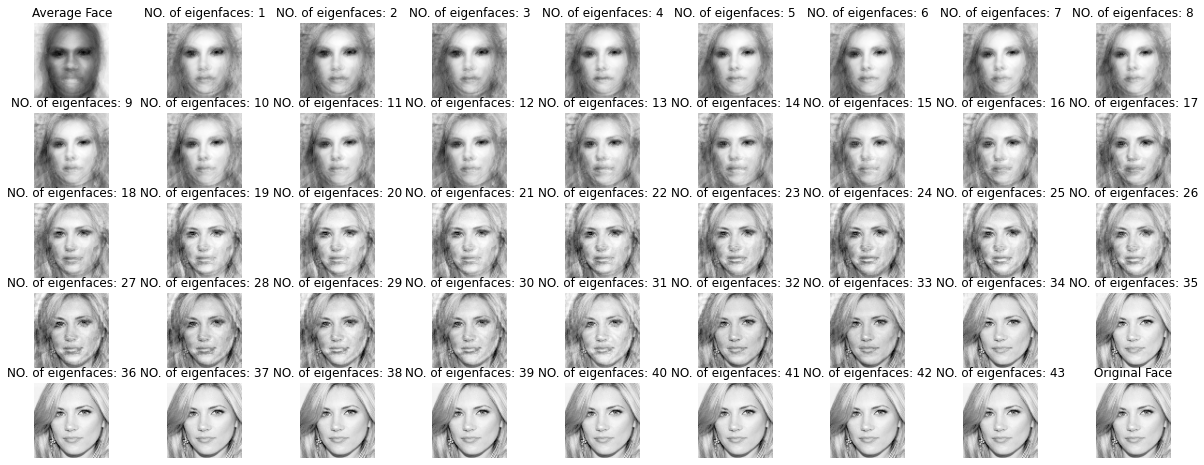

In [7]:
fig = plt.figure(figsize=(21, 8))
# average face
fig.add_subplot(5,9,1)
plt.imshow(mean_ab.reshape(80,-1),cmap = "Greys_r")
plt.title("Average Face")
plt.axis('off')
i = 2
for n in range(1,44):
    r = reconstruct(envecs,n,train_ab_norm,mean_ab)
    oneimage = r[0,:].reshape(80,-1)

    fig.add_subplot(5, 9, i)
    plt.imshow(oneimage,cmap='Greys_r')
    plt.axis('off')
    plt.title("NO. of eigenfaces: %d" % n)
    i += 1
fig.add_subplot(5,9,i)
plt.imshow(train_ab[0,:].reshape(80,-1), cmap='Greys_r')
plt.axis('off')
plt.title("Original Face")

###***Person B: First image face***

Text(0.5, 1.0, 'Original Face')

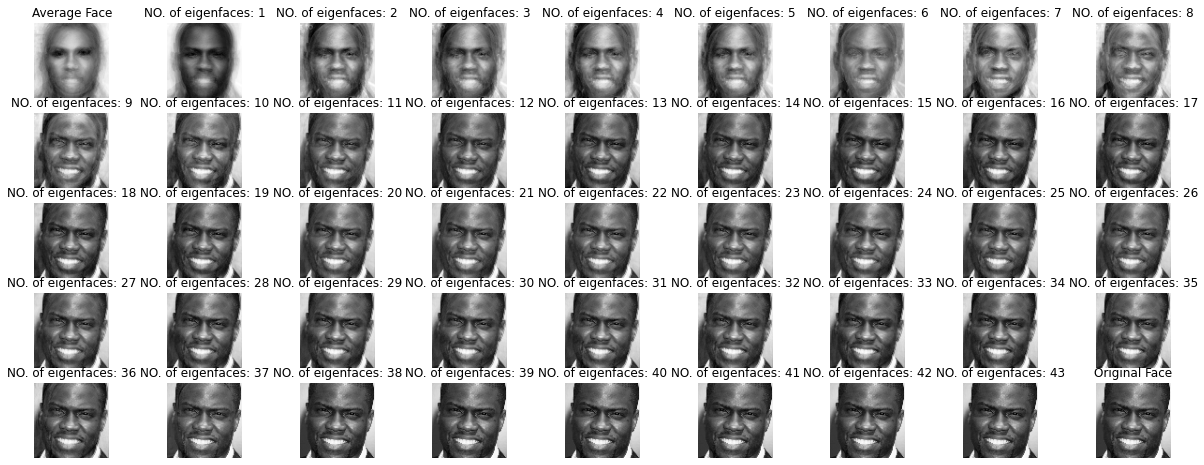

In [8]:
fig = plt.figure(figsize=(21, 8))
# average face
fig.add_subplot(5,9,1)
plt.imshow(mean_ab.reshape(80,-1),cmap = "Greys_r")
plt.title("Average Face")
plt.axis('off')
i = 2
for n in range(1,44):
    r = reconstruct(envecs,n,train_ab_norm,mean_ab)
    oneimage = r[20,:].reshape(80,-1)

    fig.add_subplot(5, 9, i)
    plt.imshow(oneimage,cmap='Greys_r')
    plt.axis('off')
    plt.title("NO. of eigenfaces: %d" % n)
    i += 1
fig.add_subplot(5,9,i)
plt.imshow(train_ab[20,:].reshape(80,-1), cmap='Greys_r')
plt.axis('off')
plt.title("Original Face")

## **(4) Choose the optimal number p of principal components**

In [0]:
# Scree plot
def screeplot(eigenvalues,pc_number):
  list_eigenvalue = []
  for n in range(0,pc_number):
      e_vals = eigenvalues[n]
      list_eigenvalue.append(e_vals)
  fig = plt.figure(figsize=(10, 3))
  plt.plot(range(1,pc_number+1),np.real(list_eigenvalue),'b',label="Eigenvalue")
  plt.xticks(np.arange(0,pc_number+1))
  plt.grid(axis='x',linestyle='-.')
  plt.legend(loc="center right")
  plt.ylabel("Eigenvalue")
  plt.xlabel("Component number")
  plt.title("Figure1-1 Scree Plot")
  plt.show()
  print(np.real(list_eigenvalue))

# Percentage of variance accounted for (accumulated)
def accumulated(eigenvalues,number_pcs):
  e_vals = eigenvalues[:number_pcs]
  percent = np.cumsum(e_vals)/sum(eigenvalues)
  fig = plt.figure(figsize=(10, 3))
  plt.plot(range(1,number_pcs+1),np.real(percent),'b', label="Percent of Variance Captured")
  plt.legend(loc="center right")
  plt.xticks(np.arange(0,number_pcs+1))
  plt.grid(axis='x',linestyle='-.')
  plt.ylabel("Accumulated Percentage")
  plt.xlabel("Number of Principal Components")
  plt.title("Figure1-2 Accumlated Percentage of variance accounted")
  plt.show()

# MSE plot
def mse(reconstruction,original):
  error = original - reconstruction
  squared = error*error
  loss = squared.sum(1).mean()
  return loss

def mseplot(eigenvector,dataset,dataset_mean,dataset_original,number_pcs):
  list_mse = []
  for n in range(0,number_pcs+1):
    r = reconstruct(eigenvector,n,dataset,dataset_mean) 
    loss = mse(r,dataset_original)
    list_mse.append(loss)
  fig = plt.figure(figsize=(10, 3))
  plt.plot(range(0,number_pcs+1),list_mse,'r', label="MSE of Reconstruction from Original")
  plt.legend(loc="center right")
  plt.xticks(np.arange(0,number_pcs+1))
  plt.grid(axis='x',linestyle='-.')
  plt.ylabel("Mean Squared error")
  plt.xlabel("Number of Principal Components")
  plt.title("Figure1-3 Average construction loss")
  plt.show()

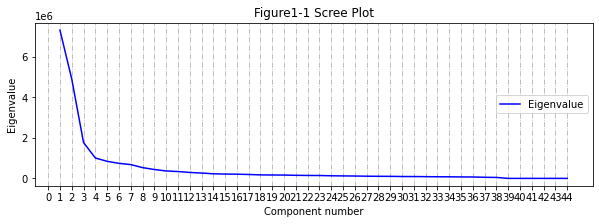

[7.32151480e+06 4.91124697e+06 1.77086265e+06 1.00708562e+06
 8.42200734e+05 7.42817563e+05 6.81690596e+05 5.32950098e+05
 4.38213549e+05 3.67119615e+05 3.38469879e+05 2.93440074e+05
 2.64656634e+05 2.26597266e+05 2.13557536e+05 2.07088505e+05
 1.92632919e+05 1.72587680e+05 1.66926668e+05 1.63841614e+05
 1.51900847e+05 1.45090925e+05 1.42086492e+05 1.28777383e+05
 1.21715021e+05 1.17323763e+05 1.07798207e+05 1.02657469e+05
 1.01011346e+05 9.25362086e+04 9.10867971e+04 8.56562826e+04
 8.00587721e+04 7.81517466e+04 7.15698013e+04 6.91677611e+04
 5.42981942e+04 4.68830139e+04 2.69320181e-10 2.36127827e-10
 2.36127827e-10 1.35434236e-10 1.27197729e-10 1.03903755e-10]


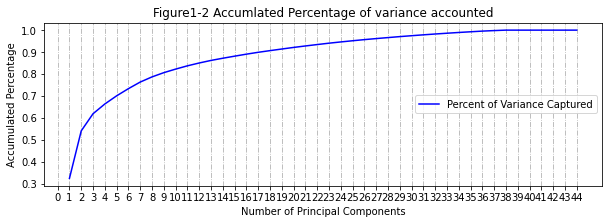

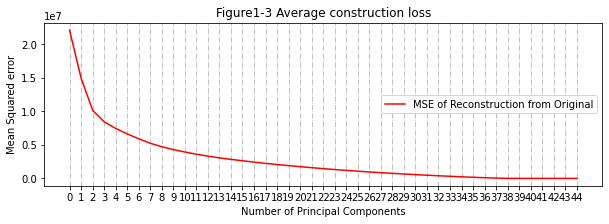

In [10]:
screeplot(envals,44)
accumulated(envals,44)
mseplot(envecs,train_ab_norm,mean_ab,train_ab,44)

According to the Scree plot (Figure 1-1) and percentage plot (Figure 1-2), the first 38 principle components explained nearly 100% of the total variance and had eigenvalues much larger than 1. Starting from the 39th principle component, the eigenvalue is much smaller than 1 and near 0. Besides, average construction loss plot (Figure 1-3) shows that mean squared error for 38 principal components in training set is nearly zero. These 38 principal components are hence chosen for further analysis.

##**(5) Visualize the faces in the principal component space**

In [0]:
def eigenface(eigenvector,number_pcs):
  e_vecs = eigenvector[:,range(number_pcs)].real
  fig = plt.figure(figsize=(15, 10))
  for n in range(0,number_pcs):
    e_faces = e_vecs[:,n].reshape(80,-1)
    fig.add_subplot(5, 8, n+1)
    plt.imshow(e_faces,cmap='Greys_r')
    plt.axis('off')
    plt.title("Eignface "+str(n+1))

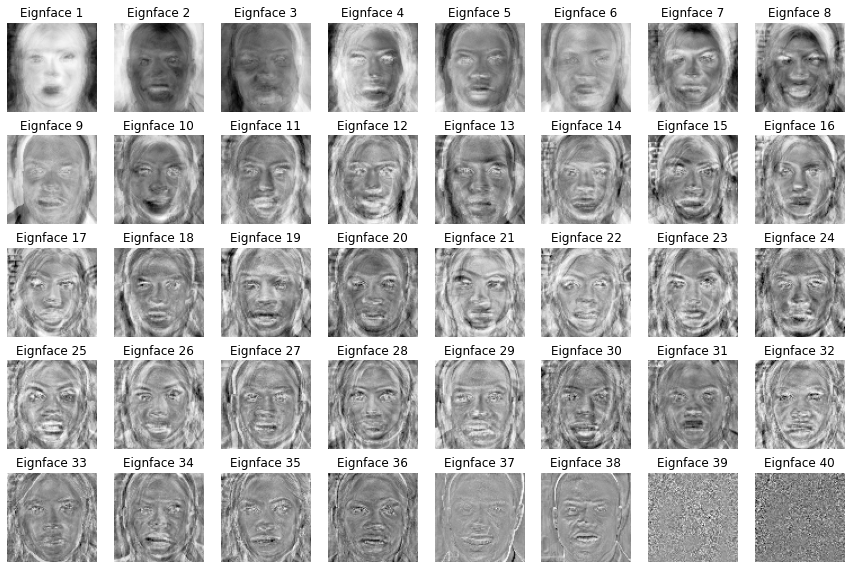

In [12]:
eigenface(envecs,40)

Eigenface also clearly indicates that 38 principle components are suitable.

##**(6) Project the test images onto the same p-components and visualize**

[[ 3165.1614242   3409.11927856  2021.3954848   1205.72739324
   2615.24278787  3339.59596968  2732.2489798   2197.35338803
   1656.1536312   2410.87461563 -1998.06623144 -1754.64284602
  -1604.13672319  2155.7278173  -2768.04223146 -1268.36538127
   -926.8720369   -421.42167634 -2194.17697666 -1738.0055382 ]
 [ -527.93536153  -270.59947494 -1150.1252582  -1083.43917013
   3837.1315775     14.73247808   123.62259469 -2285.22929462
  -1842.4233109   1024.40664538   569.39984261 -1890.58022369
   3917.19470803  4627.80738376 -3900.9559344  -4284.2804996
  -5897.44045081 -1441.37267559  1518.42105848  2633.37979862]]


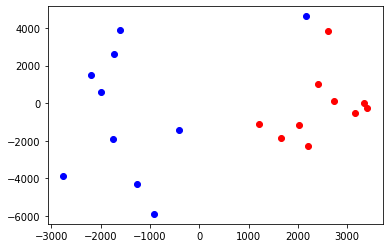

In [25]:
vecs = envecs[:,range(2)].real
# projection of the data in the new space
proj = np.dot(vecs.T,test_ab_norm)
print(proj)
for n in range(0,10):
  plt.scatter(proj[0,n],proj[1,n],color = "r")
for n in range(10,20):
  plt.scatter(proj[0,n],proj[1,n],color = "b")
# Reconstructing original images from the projection
r_test = reconstruct(envecs,2,test_ab_norm,mean_ab)
# Visualize one face
#for n in range(0,10):
#  plt.imshow(a_r_test[n,:].reshape(80,-1),cmap='Greys_r')

##**(7) Build PCA feature representations**

In [0]:
def pcafeature(eigenvector, dataset_norm, num_pcs):
  envecs = eigenvector[:,range(num_pcs)].real
  proj = np.dot(envecs.T,dataset_norm)
  #feature_1 = np.vstack((proj_1,np.ones(proj_1.shape[1])))
  #feature_0 = np.vstack((proj_0,np.zeros(proj_0.shape[1])))
  #data_pca = np.hstack((feature_1,feature_0)).T
  data_pca_x = proj
  return data_pca_x

In [15]:
training_ab_x = pcafeature(envecs,train_ab_norm,38).T
testing_ab_x = pcafeature(envecs,test_ab_norm,38).T
testing_cd_x = pcafeature(envecs,test_cd_norm,38).T
training_ab_y = np.hstack((np.ones(20),np.zeros(20)))
testing_ab_y = np.hstack((np.ones(10),np.zeros(10)))
testing_cd_y = np.hstack((np.ones(10),np.zeros(10)))
print(training_ab_x.shape)
print(training_ab_y.shape)

(40, 38)
(40,)


#**5.1 Classification**

***Logistic regression***

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
logmodel = LogisticRegression('l2')
logmodel.fit(training_ab_x,training_ab_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
#predictions
predict_ab_lr = logmodel.predict(testing_ab_x)
predict_cd_lr = logmodel.predict(testing_cd_x)

print(classification_report(testing_ab_y,predict_ab_lr))
print(classification_report(testing_cd_y,predict_cd_lr))
print(predict_ab_lr)
print(predict_cd_lr)

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        10
         1.0       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        10
         1.0       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]


#**5.2 Identification**

In [39]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(training_ab_x, training_ab_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [40]:
predict_ab_knn = classifier.predict(testing_ab_x)
predict_cd_knn = classifier.predict(testing_cd_x)

print(predict_ab_knn)
print(predict_cd_knn)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
